# PyTorch: Autoencoder Fashion-MNIST
## Tabla de contenidos

- [1. Ojetivos](#objetivos)
- [2. Obtención y preparación del dataset](#dataset)
- [3. Generacion del autoencoder](#generacion_autoencoder)
- [4. Comparativa SGD vs ADAM](#comparativa)
    - [4.1. SGD](#entrenamiento_sgd)
    - [4.2. ADAM](#entrenamiento_adam)
- [5. Caso de uso](#ruido_gaussiano)
    - [5.1. Comparativa aleatoria](#aleat)
    - [5.2. Comparativa arbitraria](#arb)
- [6. Refs](#refs)

<a id="objetivos"></a>
### Objetivos

El objetivo del siguiente trabajo es en primera instancia entrenar un autoencoder sobre el dataset Fashion M-NIST. Posteriormente realizar una comparativa entre el desempeño utilizando como optimizadores SGD (sthocastic gradient descent) y ADAM para los siguentes hiperparametros $n=64,128,256,512$ neuronas y un learning rate  $lr = 0.1,0.01,0.001$, tanto estos como otros posteriormente explicados fueron elegidos de forma arbitraria. Para mas información ver el informe agregado. 

Finalmente se comprobara el funcionamiento de los mejores modelos para ambos optimizadores (SGD y ADAM) de modo de limpiar un ruido gaussiano generado de manera arbitraria. 



#### Realizo los imports correspondientes

Tal vez haya algunos innecesarios, pero me sirven para copypastear rapido. 

In [1]:
import os
import pickle
import datetime
from collections import defaultdict
import shelve

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
import dill
import json

In [3]:
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [4]:
# # 1.d) 
# import google.colab
# from google.colab import files

In [5]:
# Chequeamos si la pc posee grafica
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<a id="dataset"></a>
#### Genero los correspondientes conjuntos de entrenamiento y de testeo

In [6]:
# Generate train and testing datasets 
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

Veamos los tamaños de train y test

In [7]:
len(trainset),len(testset)

(60000, 10000)

Examinamos algunas imagenes de manera aleatoria

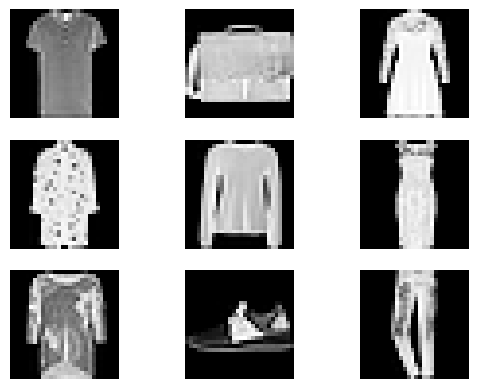

In [8]:
# 2.d)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = trainset[j]
    figure.add_subplot(rows,cols,i)
    #plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

Definimos una funcion para plotear los resultados

In [9]:
def model_test(model,image_name): #funcion para plotear los resultados
  '''
  model: Instancia del modelo 
  image_name : Nombre de la imagen de salida
  return: Una figura con la comparativa entre las imagenes originales y las generadas por el autoencoder
  '''
  figure = plt.figure()
  rows,cols = 3,2
  i = 0 # subplot index
  for row in range(1,rows+1):
      j = torch.randint(len(trainset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
      # Ploteamos la imagen original
      i += 1
      image,flatten_imagen = trainset[j]
      figure.add_subplot(rows,cols,i)
      if row==1:
        plt.title("original")
      plt.axis("off")
      plt.imshow(image.squeeze(),cmap="Greys_r")
      # Ploteamos la imagen predicha
      i += 1
      figure.add_subplot(rows,cols,i)
      if row==1:
        plt.title("predicha")
      plt.axis("off")
      #image_pred = model.imagen(image)
      #plt.imshow(image_pred,cmap="Greys_r")
      with torch.no_grad(): # 
          image_gpu = image
      pred_gpu = model(image_gpu)
      pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
      plt.imshow(pred_cpu,cmap="Greys_r")    
      
  plt.savefig(image_name)
  plt.show()

Con el fin de implementar un autoencoder, creo una clase derivada de la clase `DataSet` (`CustomDataset`) que, en lugar de retornar el label asociado a cada imagen de `FashionMNIST`, retorna la imagen misma.

Utilizo dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.

In [10]:
# Creamos una subclase de Dataset que nos sirva para muestrear imagenes en el entrenamiento del autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        label=torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
        return image,label

In [11]:
# Convertimos FashionMNIST Dataset a CustomDataset para 
trainset = CustomDataset(trainset)
testset = CustomDataset(testset)

<a id="generacion_autoencoder"></a>
## Red Neuronal Autoencoder

Creo una red neuronal de 2 capas, una oculta de $n$ neuronas y las de entrada y salida de $28\times 28=784$ neuronas.
En la capa intermedia y la de salida utilizo neuronas tipo ReLU.
Agregue un dropout de 0.1.

<!-- **b)** Grafique, comparativamente, las imagenes a predecir vs las imagenes predichas por el modelo sin entrenar. -->

In [12]:
# Defino la clase Autoencoder
class Autoencoder(nn.Module):
    def __init__(self,n):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            
            nn.Linear(28*28,n),
            nn.Dropout(0.1),
            nn.ReLU(),
            
            nn.Linear(n,28*28),
            nn.Dropout(0.1),
            nn.ReLU(),
        )
    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)

In [13]:
# Instancio el modelo con una capa interna de 64 neuronas
n = 64
model = Autoencoder(n)

Veamos como se comporta el modelo sin entrenar

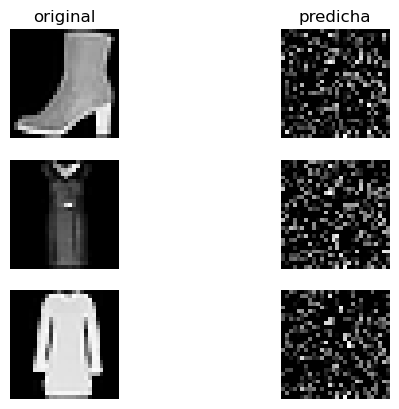

In [14]:
model_test(model,'non_trained.png')

## Entrenando el modelo

<!-- **a)** Implemente, en una función, un loop de entrenamiento que recorra los batchs.

**b)** Implemente, en una función, un loop de testeo que recorra los batchs.

**c)** Defina el rate de entrenamiento y el tamaño de los batchs en $10^{-3}$ y $1000$ respectivamente.

**d)** Inicialize los `DataLoaders` nuevamente.

**e)** Cree una función de pérdida usando la MSE-Loss y un optimizador.
Pruebe con el SGD y ADAM.

**f)** Implemente un loop de entrenamiento y testeo que recorra un numero arbitrario de épocas.
Este loop debe guardar en respectivas listas los valores de los promedios de la MSE-Loss sobre el conjunto de entrenamiento y el de testeo.

**g)** Use las listas del inciso anterior para graficar en función de las épocas la MSE-Loss de entrenamiento y la MSE-Loss de testeo.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**h)** Grafique, comparativamente, las imagenes a predecir vs las imagenes predichas por el modelo entrenado. -->

Generamos los loops de entrenamiento y de testeo que recorran los batchs

In [15]:
# Definimos la función de entrenamiento
def train_loop(dataloader,model,loss_fn,optimizer):
    # Definimos ciertas constantes
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_train_loss = 0
    # Movemos el modelo a la GPU
    model = model.to(device)
    model.train()
    # Iteramos sobre lotes (batchs)
    for batch, (X, y) in enumerate(dataloader):
        # Movemos el lote a la GPU
        X = X.to(device)
        y = y.to(device)
        # Calculamos la predicción del modelo y la correspondiente pérdida (error)
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagamos usando el optimizador proveido.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Imprimimos el progreso...
        loss_batch = loss.item()
        sum_train_loss += loss_batch
        if batch % 5 == 0:
            current = batch*len(X)
            print(f"batch={batch} loss={loss:>7f}  muestras-procesadas:[{current:>5d}/{size:>5d}]")
    avg_train_loss = sum_train_loss/num_batches
    return avg_train_loss

# De manera similar, definimos la función de testeo
def test_loop(dataloader,model,loss_fn):
    # Definimos ciertas constantes  
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_test_loss,sum_correct = 0,0
    # Movemos el modelo a la GPU
    model = model.to(device)
    model.eval()
    # Para testear, desactivamos el cálculo de gradientes.
    with torch.no_grad():
        # Iteramos sobre lotes (batches)
        for X,y in dataloader:
            # Movemos el lote a la GPU
            X,y = X.to(device),y.to(device)          
            # Calculamos las predicciones del modelo...
            pred = model(X)
            # y las correspondientes pérdidas (errores), los cuales vamos acumulando en un valor total.
            loss_batch = loss_fn(pred,y).item()
            sum_test_loss += loss_batch
            # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
            #sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Calculamos la pérdida total y la fracción de clasificaciones correctas, y las imprimimos.
    avg_test_loss = sum_test_loss/num_batches
    #frac_correct = sum_correct/size
    #print(f"Test Error: \n Accuracy: {(100*frac_correct):>0.1f}%, Avg loss: {avg_test_loss:>8f} \n")
    print(f"Test Error: Avg loss: {avg_test_loss:>8f} \n")
    return avg_test_loss

Fijamos un learning rate y un batch size (de manera arbitraria)

In [16]:
# Definimos lr y batch
learning_rate = 1e-3
batch_size = 1000

In [17]:
# Creamos los DataLoaders con el tamaño de batch elegido
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size = batch_size, shuffle = True)

Instancia basica del entrenamiento, voy a hacer una busqueda simple de algunos hiperparametros mas adelante.

NOTA IMPORTANTE : Descomentar para correr cada uno de los modelos, estan comentados dado que dentro de las carpetas estan los modelos ya entrenados guardados utilizando shelve. 

In [18]:
# #Creamos una instancia de una función de pérdida, una entropy loss en este caso
# # loss_fn = nn.CrossEntropyLoss() # Para clasificación
# loss_fn = nn.MSELoss() # Para autoencoder
# # y un optimizador, un Stochastic Gradient Descent, en este caso.
# # optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
# # o, alternativamente, un optimizador tipo ADAM.
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [19]:
# # Finalmente, entrenamos iterando sobre épocas.
# # Además, testeamos el modelo en cada una de ellas.
# num_epochs = 30
# list_avg_train_loss = []
# list_avg_test_train_loss = []
# list_avg_test_loss = []
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch+1}\n-------------------------------")
#     avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
#     avg_test_train_loss = test_loop(trainloader,model,loss_fn)
#     avg_test_loss = test_loop(testloader,model,loss_fn)
#     list_avg_train_loss.append(avg_train_loss)
#     list_avg_test_train_loss.append(avg_test_train_loss)
#     list_avg_test_loss.append(avg_test_loss)
# print("Done!")

In [20]:
# plt.xlabel('epoch')
# plt.ylabel('loss')
# #plt.xlim(-0.1,5.1)
# #plt.ylim(-0.1,1.1)
# plt.plot(list(range(1,len(list_avg_train_loss)+1)),list_avg_train_loss,label="train",linestyle='-.',c='green')
# plt.plot(list(range(1,len(list_avg_test_loss)+1)),list_avg_test_train_loss,label="test-train",linestyle='-',c='magenta')
# plt.plot(list(range(1,len(list_avg_test_loss)+1)),list_avg_test_loss,label="test",linestyle='--',c='blue')
# plt.title('')
# plt.legend()

##### Genero las carpetas donde voy a guardar los modelos entrenados. 

In [21]:
# obtengo el path absoluto
abs_path = os.getcwd()
print("Ruta absoluta: "+abs_path)

#genero la carpeta donde voy a guardar SGD
SGD_path = os.path.join(abs_path, "SGD_trained_models")
if not os.path.exists(SGD_path):
    os.mkdir(SGD_path)
    
#genero la carpeta donde voy a guardar ADAM
ADAM_path = os.path.join(abs_path, "ADAM_trained_models")
if not os.path.exists(ADAM_path):
    os.mkdir(ADAM_path)

Ruta absoluta: /media/data/Documentos de Programacion/Documentos Python/Data Science Proyects


<a id="comparativa"></a>
## Comparativa Entre SGD vs ADAM en el autoenconder

Voy a realizar una comparativa entre ambos optimizadores, para ello voy a realizar una busqueda sobre los siguentes hiperparametros $n=64,128,256,512$ neuronas y un learning rate  $lr = 0.1,0.01,0.001$. 

<a id="entrenamiento_sgd"></a>
#### Entreno el autoencoder utilizando SGD

Entreno el modelo con 100 epocas. Ademas fijo de manera arbitraria el momentum en 0.9

Ademas guardo los modelos entrenados dentro de la carpeta SGD_trained_models

In [22]:
# # SGD
# path = SGD_path + "/"
# # Las siguentes 3 lineas son puramente a fin de nombrar los archivos, probablemente pueda hacerse de una manera mas elegante.
# list_of_models = ['SGD_lr1e-1_n_','SGD_lr1e-2_n_','SGD_lr1e-3_n_'] 
# list_learning_rate = [1e-1,1e-2,1e-3]
# neuron_numbers = [64,128,256,512]

# # Entreno los distintos modelos utilizando SGD como optimizador

# for lr,model_i in enumerate(list_of_models):
    
#     for n in neuron_numbers:
        
#         model = Autoencoder(n) # Instancio el autoencoder con n neuronas en la capa intermedia
        
#         loss_fn = nn.MSELoss() # defino una funcion de perdida
        
#         optimizer = torch.optim.SGD(model.parameters(),lr=list_learning_rate[lr],momentum=0.9)
#         # optimizer = torch.optim.Adam(model.parameters(),lr=list_learning_rate[lr],eps=1e-08,weight_decay=0,amsgrad=False)
        
#         num_epochs = 100
        
#         list_avg_train_loss = []
#         list_avg_test_train_loss = []
#         list_avg_test_loss = []
#         for epoch in range(num_epochs):
#             print(f"Epoch {epoch+1}\n-------------------------------")
#             avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
#             avg_test_train_loss = test_loop(trainloader,model,loss_fn)
#             avg_test_loss = test_loop(testloader,model,loss_fn)
#             list_avg_train_loss.append(avg_train_loss)
#             list_avg_test_train_loss.append(avg_test_train_loss)
#             list_avg_test_loss.append(avg_test_loss)
#         print("Done!")

        
#         models = shelve.open(path + model_i+str(n)+'.db')
#         models['auto']=model
#         models['train_loss']= list_avg_train_loss
#         models['test_loss']=list_avg_test_loss
#         models['test_train_loss'] = list_avg_test_train_loss

#         models.close()
#         print(model_i +str(n)+ "Done!")

Voy a quedarme con los 4 modelos cuya loss media en test para las ultimas 10 epocas haya sido la menor

In [23]:
path = SGD_path + '/'
neuron_numbers = [64,128,256,512]
list_of_models = ['SGD_lr1e-1_n_','SGD_lr1e-2_n_','SGD_lr1e-3_n_'] 

dyct_SGD = {}

for model in list_of_models:
    for n in neuron_numbers:
        model_name = model+ str(n) +".db"
        modelos_=shelve.open(path + model_name)

        # list_avg_train_loss = modelos_['test_train_loss'][-10:].mean()  # notar que tome el test_train_loss
        best_10 = np.mean(modelos_['test_loss'][-10:])
        dyct_SGD[model_name] = best_10

In [24]:
sorted(dyct_SGD.items(), key=lambda item: item[1])[:4] # todos pertenecen a el lr de 1e-1

[('SGD_lr1e-1_n_512.db', 0.014241206953302023),
 ('SGD_lr1e-1_n_256.db', 0.01852587625384331),
 ('SGD_lr1e-1_n_128.db', 0.021262466516345738),
 ('SGD_lr1e-1_n_64.db', 0.026710779797285793)]

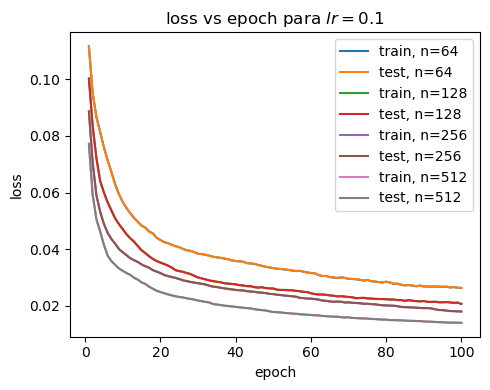

In [25]:
# graficador de loss
# %matplotlib qt
path = SGD_path + '/'
neuron_numbers = [64,128,256,512]
# list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 
list_of_models = ['SGD_lr1e-1_n_']
plt.figure(figsize=(5,4))
for i, model in enumerate(list_of_models):
    for n in neuron_numbers:
        modelos_=shelve.open(path + model + str(n) +".db")

        list_avg_train_loss = modelos_['test_train_loss']
        list_avg_test_loss = modelos_['test_loss']
        plt.xlabel('epoch')
        plt.ylabel('loss')
        # plt.xlim(80,106)
        # plt.ylim(0.005,0.018)
        plt.plot(range(1,len(list_avg_train_loss)+1),list_avg_train_loss,label="train"+", n="+str(n))
        plt.plot(range(1,len(list_avg_test_loss)+1),list_avg_test_loss,label= "test"+", n="+str(n))
        plt.title('loss vs epoch para $lr = 0.1$')
        plt.tight_layout()
        plt.legend()

plt.savefig('SGD_best_loss.png')

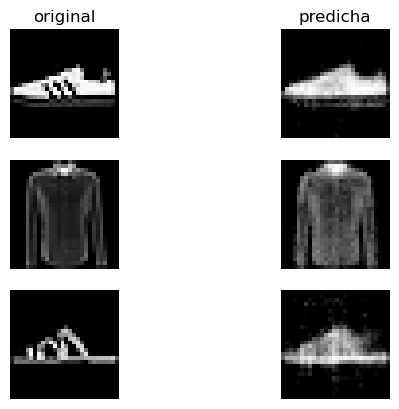

In [26]:
path = SGD_path + "/"
best_SGD = "SGD_lr1e-1_n_"+ str(512)
modelos_=shelve.open(path +  best_SGD +".db")

best_SGD_model = modelos_['auto'] 
model_test(best_SGD_model,model_name +'.png')

<a id="entrenamiento_adam"></a>
#### Entreno el autoencoder utilizando ADAM

Entreno el modelo con 100 epocas. 

Ademas guardo los modelos entrenados dentro de la carpeta ADAM_trained_models

In [27]:
# #ADAM
# path = ADAM_path + "/"
# # Las siguentes 3 lineas son puramente a fin de nombrar los archivos, probablemente pueda hacerse de una manera mas elegante.

# list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 
# list_learning_rate = [1e-1,1e-2,1e-3]
# neuron_numbers = [64,128,256,512]

# for lr,model_i in enumerate(list_of_models):
    
#     for n in neuron_numbers:
        
#         model = Autoencoder(n) # instancio el Autoencoder
        
#         loss_fn = nn.MSELoss() # Defino una funcion de perdida
        
#         # Utilizo como optimizador Adam
#         optimizer = torch.optim.Adam(model.parameters(),lr=list_learning_rate[lr],eps=1e-08,weight_decay=0,amsgrad=False)
        
#         num_epochs = 1
        
#         list_avg_train_loss = []
#         list_avg_test_train_loss = []
#         list_avg_test_loss = []
#         for epoch in range(num_epochs):
#             print(f"Epoch {epoch+1}\n-------------------------------")
#             avg_train_loss = train_loop(trainloader,model,loss_fn,optimizer)
#             avg_test_train_loss = test_loop(trainloader,model,loss_fn)
#             avg_test_loss = test_loop(testloader,model,loss_fn)
#             list_avg_train_loss.append(avg_train_loss)
#             list_avg_test_train_loss.append(avg_test_train_loss)
#             list_avg_test_loss.append(avg_test_loss)
#         print("Done!")

        
#         models = shelve.open(path + model_i+str(n)+'.db')
#         models['auto']=model
#         models['train_loss']= list_avg_train_loss
#         models['test_loss']=list_avg_test_loss
#         models['test_train_loss'] = list_avg_test_train_loss

#         models.close()
#         print(model_i +str(n)+ "Done!")

Voy a quedarme con los 4 modelos cuya loss media en test para las ultimas 10 epocas haya sido la menor

In [28]:
path = ADAM_path + '/'
neuron_numbers = [64,128,256,512]
list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 

dyct_adam = {}

for model in list_of_models:
    for n in neuron_numbers:
        model_name = model+ str(n) +".db"
        modelos_=shelve.open(path + model_name)

        # list_avg_train_loss = modelos_['test_train_loss'][-10:].mean()  # notar que tome el test_train_loss
        best_10 = np.mean(modelos_['test_loss'][-10:])
        dyct_adam[model_name] = best_10

In [29]:
sorted(dyct_adam.items(), key=lambda item: item[1])[:4] # todos pertenecen a el lr de 1e-3

[('adam_lr1e-3_n_512.db', 0.007386826062574983),
 ('adam_lr1e-3_n_256.db', 0.009186674281954767),
 ('adam_lr1e-3_n_128.db', 0.010878186654299498),
 ('adam_lr1e-3_n_64.db', 0.015299956137314438)]

Vemos que los mejores resultados se obtienen para $lr = 0.001$

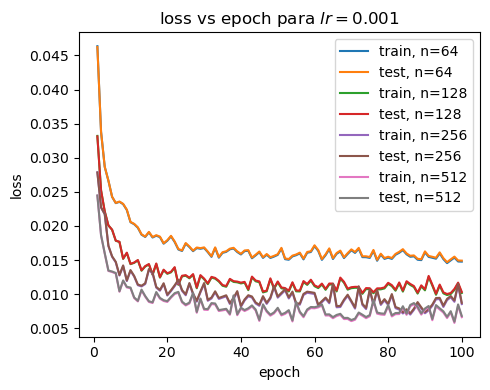

In [30]:
# graficador de loss
# %matplotlib qt
path = ADAM_path + '/'
neuron_numbers = [64,128,256,512]
# list_of_models = ['adam_lr1e-1_n_','adam_lr1e-2_n_','adam_lr1e-3_n_'] 
list_of_models = ['adam_lr1e-3_n_']
plt.figure(figsize=(5,4))
for i, model in enumerate(list_of_models):
    for n in neuron_numbers:
        modelos_=shelve.open(path + model + str(n) +".db")

        list_avg_train_loss = modelos_['test_train_loss']
        list_avg_test_loss = modelos_['test_loss']
        plt.xlabel('epoch')
        plt.ylabel('loss')
        # plt.xlim(80,106)
        # plt.ylim(0.005,0.018)
        plt.plot(range(1,len(list_avg_train_loss)+1),list_avg_train_loss,label="train"+", n="+str(n))
        plt.plot(range(1,len(list_avg_test_loss)+1),list_avg_test_loss,label= "test"+", n="+str(n))
        plt.title('loss vs epoch para $lr = 0.001$')
        plt.tight_layout()
        plt.legend()

plt.savefig('adam_best_loss.png')


Elijo el mejor modelo, en nuestro caso el que menor perdida tuvo y comparo. 

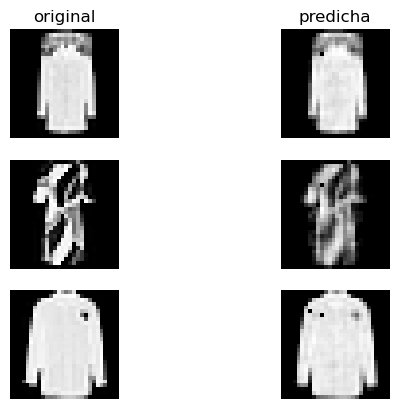

In [31]:
path = ADAM_path + "/"
best_adam = "adam_lr1e-3_n_"+ str(512)
modelos_=shelve.open(path +  best_adam +".db")

best_ADAM_model = modelos_['auto'] 
model_test(best_ADAM_model,model_name +'.png')

<a id="ruido_gaussiano"></a>
## Uso del autoencoder como limpiador de ruido gaussiano

Voy a comparar los mejores modelos obtenidos con cada optimizador como denoising. Para ello voy a generar ruido gaussiano el cual voy a suavizar mediante una constante `soft` (Mayor el valor de soft, menor el ruido introducido)

In [32]:
class AddGaussianNoise(ToTensor):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor,soft):
        return tensor + (torch.randn(tensor.size()) * self.std + self.mean)/soft
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

Probamos como funciona el ruido gaussiano

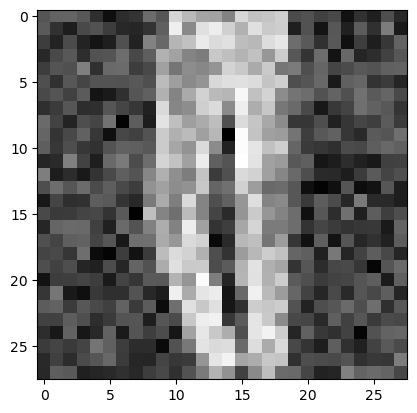

In [33]:
soft = 7
image_gau = AddGaussianNoise().__call__(image,soft)
plt.imshow(image_gau.squeeze(),cmap='Greys_r')

<a id="aleat"></a>
#### Comparativa aleatoria

Genero una comparativa entre las imagenes originales, las ruidosas, las limpiadas con el modelo de SGD y las limpiadas con ADAM.

6101 1
3283 2
5844 3
346 4


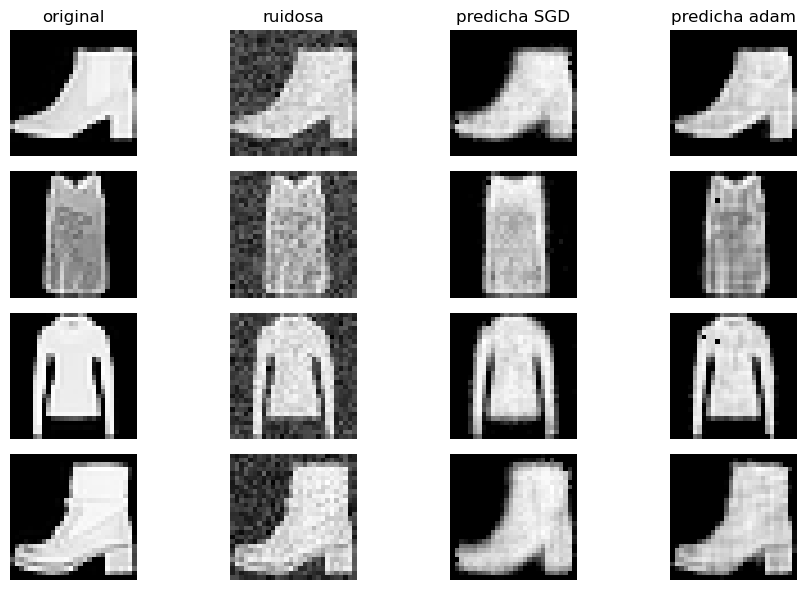

<Figure size 640x480 with 0 Axes>

In [34]:
# los mejores modelos ya los seleccione previamente
model_adam = best_ADAM_model
model_SGD = best_SGD_model

figure = plt.figure(figsize=(10,6))
rows,cols = 4,4
soft=11
i = 0 # subplot index
# jotas = [5087]
for row in range(1,rows+1):
    j = torch.randint(len(testset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    print(j,row)
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = testset[j]
    # image = AddGaussianNoise().__call__(image,soft)
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # ploteamos la imagen ruidosa
    i += 1
    image,flatten_imagen = testset[j]
    image = AddGaussianNoise().__call__(image,soft)
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("ruidosa")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha con sgd
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha SGD")
    plt.axis("off")

    
    with torch.no_grad(): # 
        image_gpu = image
    pred_gpu1 = model_SGD(image_gpu)
    pred_cpu1 = pred_gpu1.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu1,cmap="Greys_r")   
     
    # Ploteamos la imagen predicha con adam
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha adam")
    plt.axis("off")

    
    with torch.no_grad(): # 
        image_gpu = image
    pred_gpu2 = model_adam(image_gpu)
    pred_cpu2 = pred_gpu2.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu2,cmap="Greys_r")    
    
    plt.tight_layout()
    
plt.show()
plt.savefig('Comparacion de modelos.png')

<a id="arb"></a>
#### Comparativa arbitraria

En la siguiente comparativa se aprecian en razgos generales el comportamiento de ambos modelos como denoising. Estos fueron elegidos de manera arbitraria para repesentar lo observado en general. Ademas es la imagen que se aprecia en el informe. 

346 1
4843 2
4053 3
5105 4


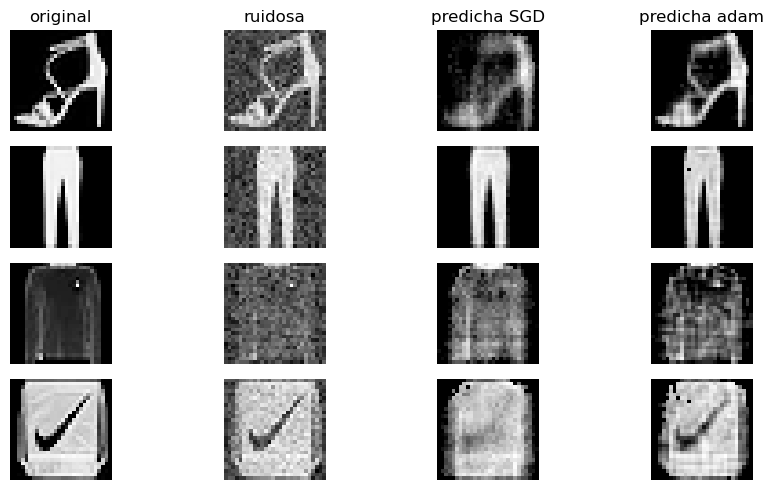

In [35]:
jotas=[4843,4053,5105,8568 ]

figure = plt.figure(figsize=(10,5))
rows,cols = 4,4
soft=9
i = 0 # subplot index
# jotas = [5087]
for row in range(1,rows+1):
    # j = torch.randint(len(testset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    print(j,row)
    j = jotas[row-1]
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = testset[j]
    # image = AddGaussianNoise().__call__(image,soft)
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # ploteamos la imagen ruidosa
    i += 1
    image,flatten_imagen = testset[j]
    image = AddGaussianNoise().__call__(image,soft)
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("ruidosa")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha con sgd
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha SGD")
    plt.axis("off")

    
    with torch.no_grad(): # 
        image_gpu = image
    pred_gpu1 = model_SGD(image_gpu)
    pred_cpu1 = pred_gpu1.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu1,cmap="Greys_r")   
     
    # Ploteamos la imagen predicha con adam
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha adam")
    plt.axis("off")

    
    with torch.no_grad(): # 
        image_gpu = image
    pred_gpu2 = model_adam(image_gpu)
    pred_cpu2 = pred_gpu2.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu2,cmap="Greys_r")    
    
    plt.tight_layout()
    
# plt.show()
plt.savefig('Comparacion de modelos.png')

<a id="refs"></a>
## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

